# Extracting Representations from all the layers of a Deep Neural Networks




One of the most basic and useful operations on a deep network is the extraction
of representations from its hidden layers.

The reason is that representations are in themselves a remarkable object of
investigation. 
Representations are the encoding of the data at a given layer, and their categorical
content can be decoded from there.
The performance of this decoding can tell us how explicitly the categorical information is contained in the representation.
In this hands-on session we will extract representations from hidden layers, and we will take a look at how they evolve along the hidden layers with the Representation Similarity Matrix tecnique.

<img src="../NotebooksFigures/mnist_complete.jpg" alt="drawing" width="300" >



In [8]:
# imports

import os
import os.path as path
from os import listdir 
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import h5py

from keras.datasets import mnist
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K

# Load data

We load a sample of data to work with. We will sample it from the test set.

In [9]:
(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_test_int = l_test # keep labels in integer form
l_train, l_test = to_categorical(l_train), to_categorical(l_test)

In [10]:
# extract a random sample of n_sample elements from each category in test set

n_samples = 100
samples = np.zeros((n_samples*10,28,28,1))
labels = np.zeros((n_samples*10,))
for i in range(10):
    mask = l_test_int == i
    temp_i_test = i_test[mask]
    idx = np.random.permutation(temp_i_test.shape[0])[:n_samples]
    samples[i*n_samples: (i+1)*n_samples,:,:,:] = temp_i_test[idx]
    labels[i*n_samples: (i+1)*n_samples] = np.zeros((n_samples,)) + i
labels = to_categorical(labels)

In [11]:
print(samples.shape)
print(labels.shape)

(1000, 28, 28, 1)
(1000, 10)


# Load pre-trained model

We load a pre-trained multi-layer perceptron (MLP) with 3 hidden layers

In [12]:
model = load_model(join('models', 'mlp3.h5'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________
None


# Extraction

In order to extract representations Keras has an elegant solution.
Look at the following thread in stackoverflow for the relative discussion :
https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer




In [13]:
def extract_representations(model):
    inp = model.input                                           # input placeholder
    outputs = [layer.output for layer in model.layers]          # all layer outputs
    functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function
    layer_outs = functor([samples, 1.])
    return layer_outs

In [14]:
layer_outs = extract_representations(model)

In [15]:
# check that the output shapes are correct, let'use list comprehension 

_ = [print(l.name, lo.shape) for l,lo in zip(model.layers, layer_outs)]

images (1000, 28, 28, 1)
flatten_1 (1000, 784)
hidden1 (1000, 100)
hidden2 (1000, 100)
hidden3 (1000, 100)
output (1000, 10)


# Representation Similarity Matrix


We take a look at how representations evolve along the depth of the MLP.
In order to do that we build in each layer the Representation Similarity Matrix (RSM).

$RSM^{(L)}(x_i,x_j) = d^{(L)}(x_i,x_j)$

### Exercise

Exercise (Hands-on during the Lecture) : write a function that takes in input the layer outputs from flatten on and computes the RSM matrices for each layer. Then plot the RSM matrices and add titles with the names of the layers. Use the euclidean metric to measure the distances between representations, and normalize distances to the inteval [0,1] within each matrix.

Hint : use the scipy module.

Advanced (Solution not provided) : Do you notice something strange in RSM of the output layer ? What are those thin strips ? Try to figure out what is the reason behind this behavior and provide a proof by looking at explicit examples from the images involved.

### Solution

In [16]:
from scipy.spatial.distance import pdist, squareform

In [17]:
def getRSM(layer_outs):
    dists = [squareform(pdist(l,'euclidean')) for l in layer_outs]
    ndists = [1 - dist/np.max(dist) for dist in dists]
    return ndists

In [18]:
ndists = getRSM(layer_outs[1:])
names  = [l.name for l in model.layers[1:]]

_ = [print(ndist.shape) for ndist in ndists]

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)


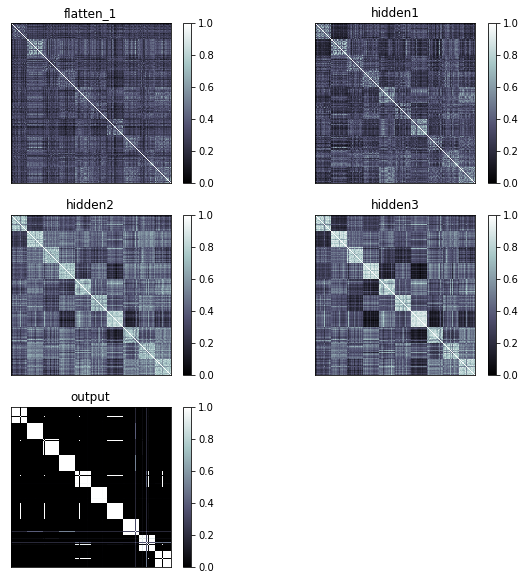

In [19]:
fig = plt.figure(figsize=(10,10))
for i, (name, ndist) in enumerate(zip(names, ndists)):    
    plt.subplot(3,2,i+1)        
    plt.imshow(ndist, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.title(name)
    plt.colorbar()
plt.show()

# Convolutional

Let us do the same with a convolutional network. We use one with 2 convolutional layers.
We will have to modify our function for the RSM computation along the way.

In [20]:
model = load_model(join('models', 'convolutional_2layers.h5'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 40)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 40)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               576100    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 578,150
Trainable params: 578,150
Non-trainable params: 0
_________________________________________________________________
None

In [21]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function
layer_outs = functor([samples, 1.])

In [22]:
_ = [print(l.name, lo.shape) for l,lo in zip(model.layers, layer_outs)]

input_1 (1000, 28, 28, 1)
conv2d_2 (1000, 24, 24, 40)
max_pooling2d_2 (1000, 12, 12, 40)
flatten_1 (1000, 5760)
dense_1 (1000, 100)
dense_2 (1000, 10)


# Exercise

Exercise (Hands-on during the Lecture) : why we do have to modify our RSM extraction function ? Modify the function accordingly and then plot the RSM matrices as before.

# Solution

In [23]:
def getRSM(layer_outs):
    dists = [squareform(pdist(l.reshape(samples.shape[0],-1),'euclidean')) for l in layer_outs]
    ndists = [1 - dist/np.max(dist) for dist in dists]
    return ndists

In [24]:
# now is no more required to leave out the input layer

ndists = getRSM(layer_outs)
names  = [l.name for l in model.layers]

_ = [print(ndist.shape) for ndist in ndists]

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)


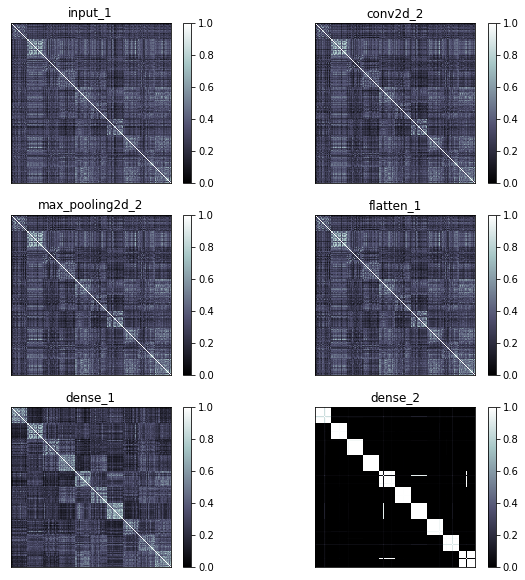

In [25]:
fig = plt.figure(figsize=(10,10))
for i, (name, ndist) in enumerate(zip(names, ndists)):    
    plt.subplot(3,2,i+1)        
    plt.imshow(ndist, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.title(name)
    plt.colorbar()
plt.show()

Observation : in our solution we treated the flattening layer as a layer in itself, but it is just a reshaped replica of the preceding max pooling layer (the two RSM are indeed identical). This flattening layer usually appears before the stack of dense layers.

Exercise : Try to modify the code in order to rule out duplicates. Try to modify the code in order to extract representations only from input, pooling and fully connected layers.